In [1]:
import ultraplot as uplt
import matplotlib as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio as rio
from rasterio.plot import show
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches
from shapely import wkt
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.transform import array_bounds
import rasterio.mask as rmask
from shapely import Polygon

In [2]:
arnot_forest = rio.open('./Data/Defol_Eval/defol_eval_arnot_forest_2022.tif')
mt_pleasant = rio.open('./Data/Defol_Eval/defol_eval_mt_pleasant_2021.tif')
allegheny = rio.open('./Data/Defol_Eval/defol_eval_allegheny_2021.tif')
turkey_point = rio.open('./Data/Defol_Eval/defol_eval_turkey_point_2021.tif')

In [3]:
dest_crs = ccrs.AlbersEqualArea(central_longitude=-76.0, central_latitude=42.0,)

def prepare_for_viz(raster_file, dest_crs, mask_polygon=None):
    if mask_polygon is not None:
        orig_image, orig_transform = rmask.mask(raster_file, [mask_polygon], crop=True)
    else:
        orig_image = raster_file.read()
        orig_transform = raster_file.transform
        
    transform, width, height = calculate_default_transform(
        raster_file.crs, dest_crs, raster_file.width, raster_file.height, *raster_file.bounds)
    
    new_image, new_transform = reproject(
        source=orig_image,
        src_transform=orig_transform,
        src_crs=raster_file.crs,
        dst_crs=dest_crs,
        resampling=Resampling.nearest,
        dst_nodata=np.nan)
    
    new_bounds = array_bounds(new_image.shape[1], new_image.shape[2], new_transform)
    #new_image = np.concatenate([new_image, new_image, new_image])
    new_image = new_image.transpose([1, 2, 0])
    new_image[:, :, 0:3] = np.clip(new_image[:, :, 0:3] / 1000, 0, 1)
    
    # Create a nan mask
    alpha_channel = ~np.isnan(new_image[:, :, [0]])
    new_image = np.concatenate([new_image, alpha_channel], axis=2)

    return new_image, new_bounds

arnot_forest_reproj, arnot_forest_reproj_bounds = prepare_for_viz(arnot_forest, dest_crs)
mt_pleasant_reproj, mt_pleasant_reproj_bounds = prepare_for_viz(mt_pleasant, dest_crs)
allegheny_reproj, allegheny_reproj_bounds = prepare_for_viz(allegheny, dest_crs)
turkey_point_reproj, turkey_point_reproj_bounds = prepare_for_viz(turkey_point, dest_crs)

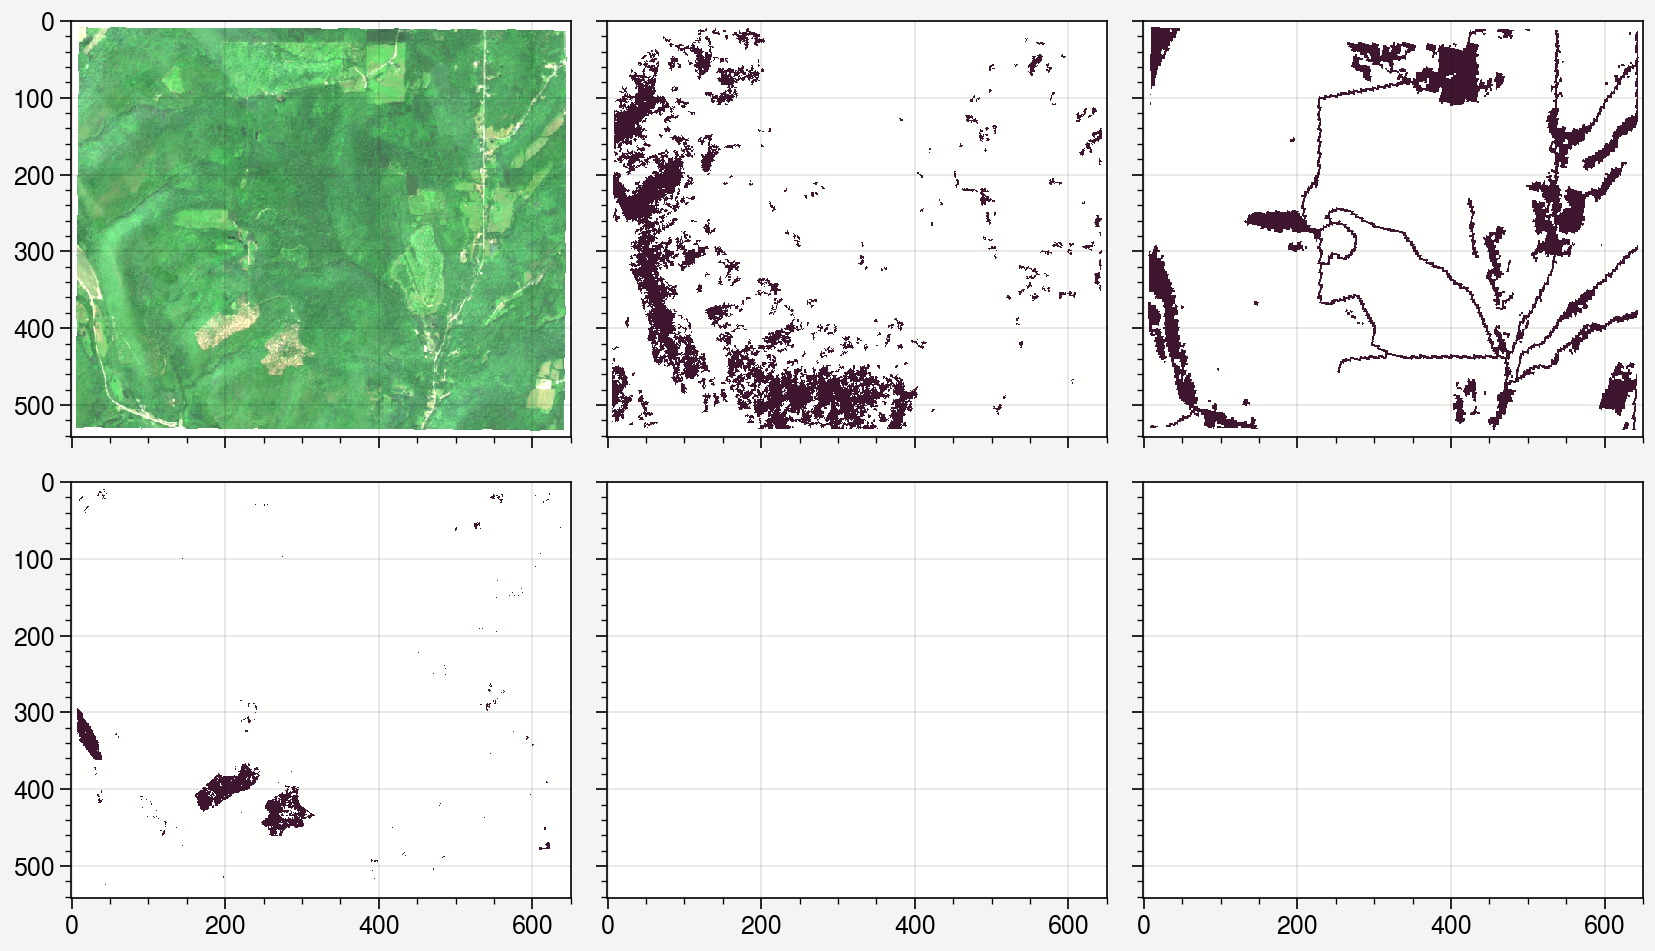

In [4]:
fig, axes = uplt.subplots(ncols=3, nrows=2)

axes[0].imshow(arnot_forest_reproj[:, :, [0, 1, 2, -1]])

axes[1].imshow(arnot_forest_reproj[:, :, 3])
axes[2].imshow(arnot_forest_reproj[:, :, 4])
axes[3].imshow(arnot_forest_reproj[:, :, 5])
axes[4].imshow(arnot_forest_reproj[:, :, 6])

In [5]:
# Take an image, a nan color, and a palette for an integer valued array (expressed as 2-d array of color values)
def apply_palette(image, nan_color, palette):
    nan_image = np.tile(np.array([[[0, 0, 0, 0]]]), (image.shape[0], image.shape[1], 1))
    sanitized_image = np.nan_to_num(image).astype(int)
    
    nan_test = np.tile(np.isnan(image), (4, 1, 1)).transpose([1, 2, 0])
    return np.where(nan_test, nan_image, palette[sanitized_image])

In [6]:
def plot_condition(ax, image, crs, extent):
    ax.imshow(image[:, :, [0, 1, 2, -1]], transform=crs, origin='upper',
              extent=extent)

    # Add Defoliation classes
    defol_palette = np.array([[0, 0, 0, 0],
                              [255, 0, 0, 255]])
    defol = apply_palette(image[:, :, 3], [0, 0, 0, 0], defol_palette)
    ax.imshow(defol, zorder=2, transform=crs, origin='upper',
              extent=extent)

    # Add Landcover
    landcover_palette = np.array([[0, 0, 0, 0],
                                  [0, 0, 0, 255]])
    landcover = apply_palette(image[:, :, 4], [0, 0, 0, 0], landcover_palette)
    ax.imshow(landcover, zorder=3, transform=crs, origin='upper',
              extent=extent)

    # Add Logging
    logging_palette = np.array([[0, 0, 0, 0],
                                [255, 255, 0, 255]])
    logging = apply_palette(image[:, :, 5], [0, 0, 0, 0], logging_palette)
    ax.imshow(logging, zorder=2, transform=crs, origin='upper',
              extent=extent)

    # Add Observation
    obs_palette = np.array([[0, 0, 0, 0],
                            [0, 0, 255, 255]])
    obs = apply_palette(image[:, :, 6], [0, 0, 0, 0], obs_palette)
    ax.imshow(obs, zorder=2, transform=crs, origin='upper',
              extent=extent)
    
    ax.set_extent(extent, crs=crs)

In [7]:
np.unique(turkey_point_reproj[:, :, 4])

array([ 0., nan], dtype=float32)

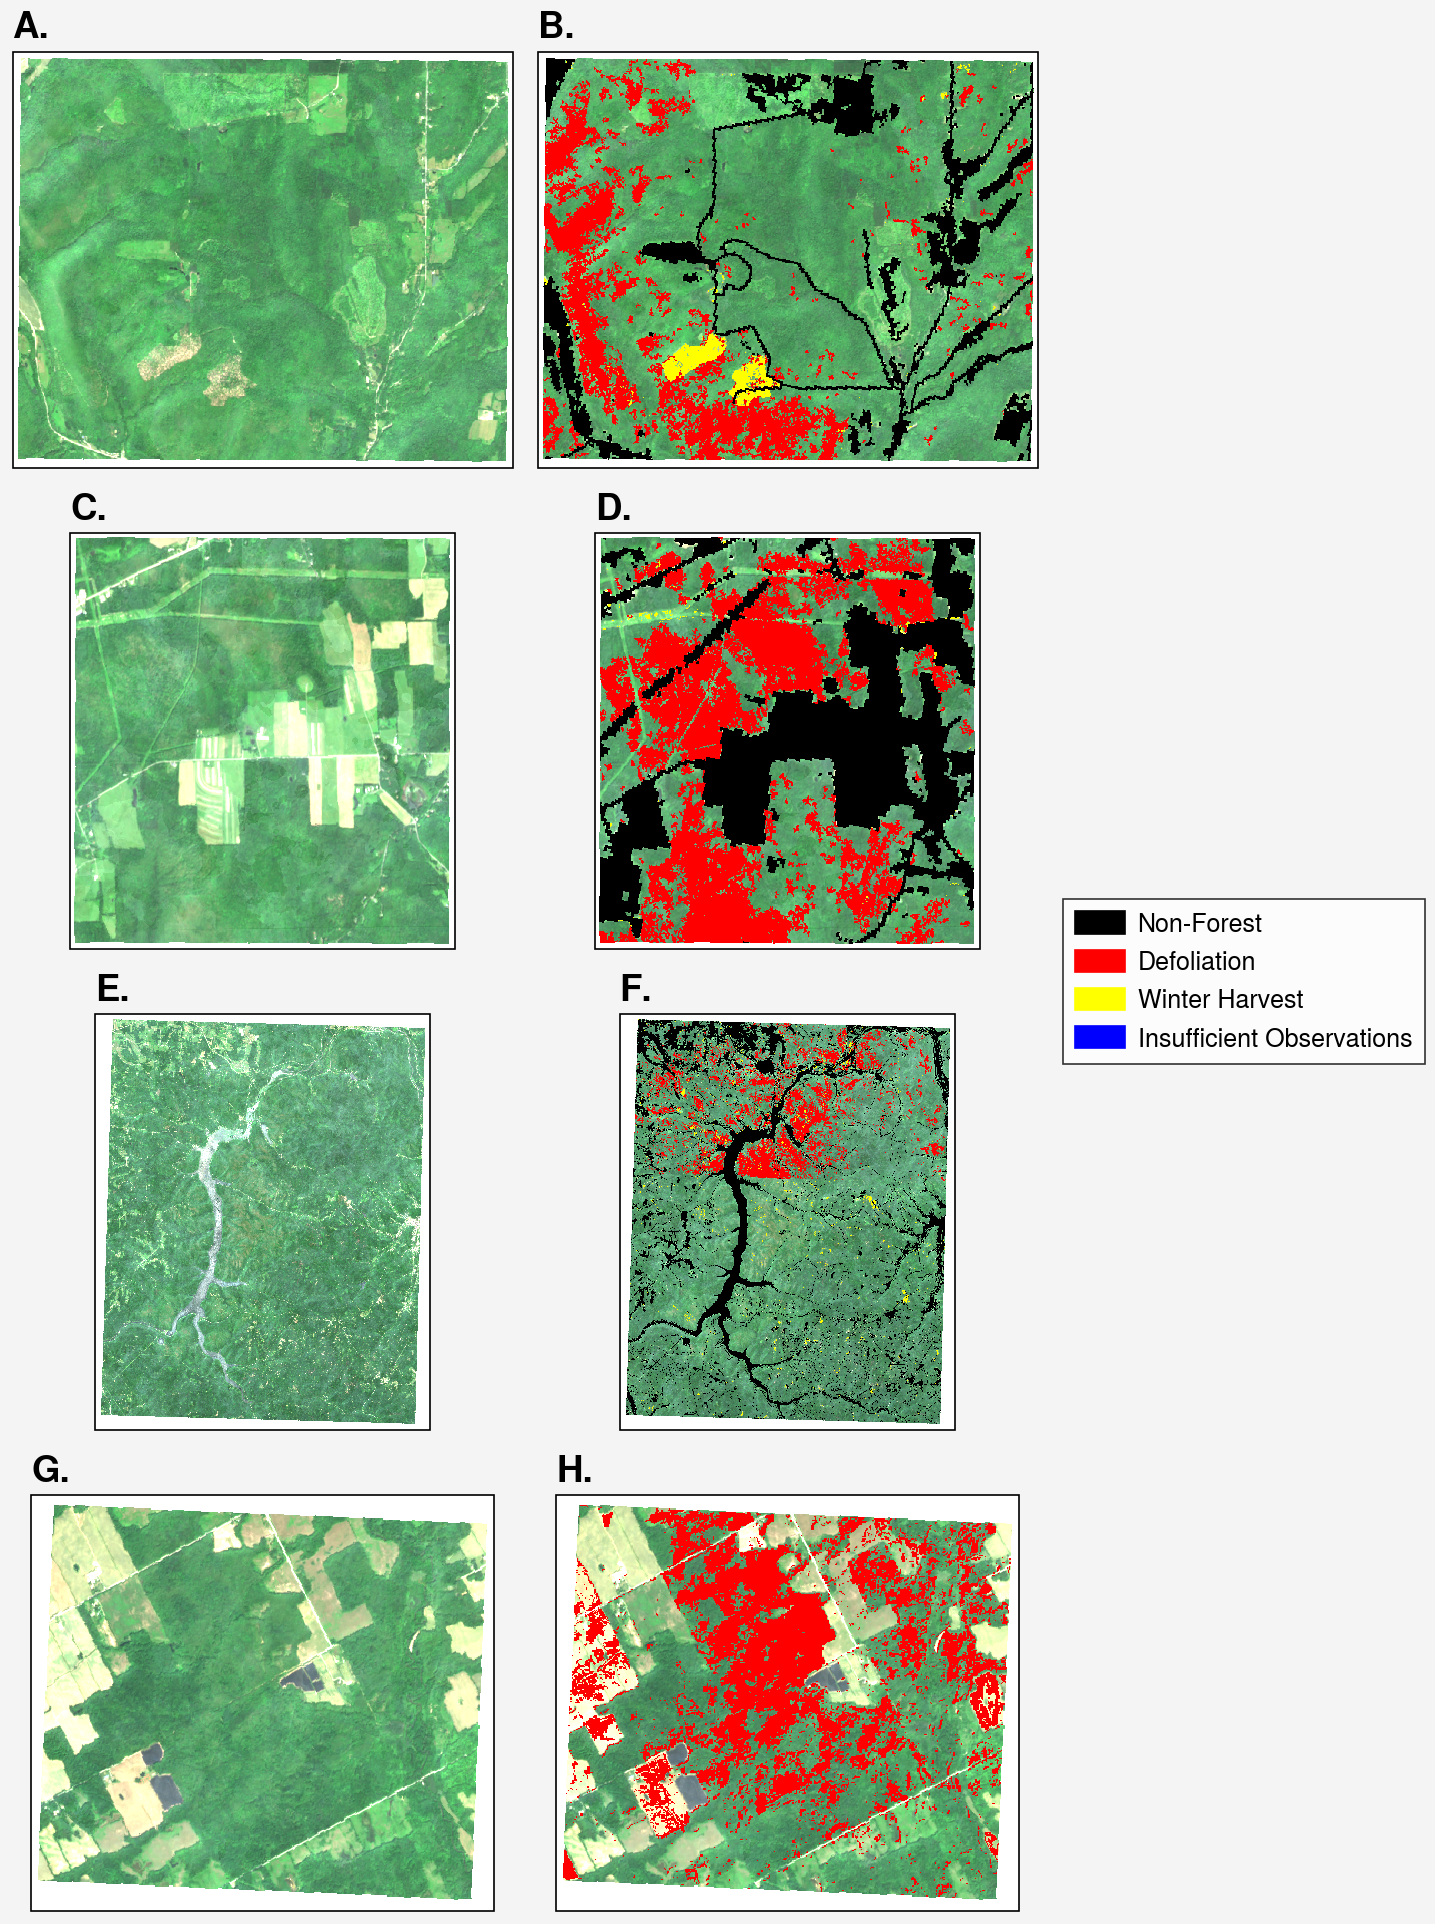

In [12]:
fig, axes = uplt.subplots(ncols=2, nrows=4, share=False, proj=dest_crs, fontsize=12)

axes.format(abc='A.', abcloc='l')

# Arnot Forest
af_extent = [arnot_forest_reproj_bounds[0], arnot_forest_reproj_bounds[2], arnot_forest_reproj_bounds[1], arnot_forest_reproj_bounds[3]]
axes[0].imshow(arnot_forest_reproj[:, :, [0, 1, 2, -1]], transform=dest_crs,
               extent=af_extent)
axes[0].set_extent(af_extent, crs=dest_crs)
plot_condition(axes[1], arnot_forest_reproj, dest_crs, 
               af_extent)

# Mt. Pleasant
mp_extent = [mt_pleasant_reproj_bounds[0], mt_pleasant_reproj_bounds[2], mt_pleasant_reproj_bounds[1], mt_pleasant_reproj_bounds[3]]
axes[2].imshow(mt_pleasant_reproj[:, :, [0, 1, 2, -1]], transform=dest_crs,
               extent=mp_extent)
axes[2].set_extent(mp_extent, crs=dest_crs)
plot_condition(axes[3], mt_pleasant_reproj, dest_crs,
               mp_extent)

# Allegheny
al_extent = [allegheny_reproj_bounds[0], allegheny_reproj_bounds[2], allegheny_reproj_bounds[1], allegheny_reproj_bounds[3]]
axes[4].imshow(allegheny_reproj[:, :, [0, 1, 2, -1]], transform=dest_crs,
               extent=al_extent)
axes[4].set_extent(al_extent, crs=dest_crs)
plot_condition(axes[5], allegheny_reproj, dest_crs,
               al_extent)

# Turkey Point
tp_extent = [turkey_point_reproj_bounds[0], turkey_point_reproj_bounds[2], turkey_point_reproj_bounds[1], turkey_point_reproj_bounds[3]]
axes[6].imshow(turkey_point_reproj[:, :, [0, 1, 2, -1]], transform=dest_crs,
               extent=tp_extent)
axes[6].set_extent(tp_extent, crs=dest_crs)
plot_condition(axes[7], turkey_point_reproj, dest_crs,
               tp_extent)


# Create legend
landcover_patch = mpatches.Patch(color=[0,0,0], label='Non-Forest')
defol_patch = mpatches.Patch(color=[1,0,0], label='Defoliation')
logging_patch = mpatches.Patch(color=[1,1,0], label='Winter Harvest')
obs_patch = mpatches.Patch(color=[0,0,1], label='Insufficient Observations')
fig.legend(handles=[landcover_patch, defol_patch, logging_patch, obs_patch], loc='r', ncols=1)


fig.savefig('./Figures/Defol_Eval/New_York_study_site_comparison.png')

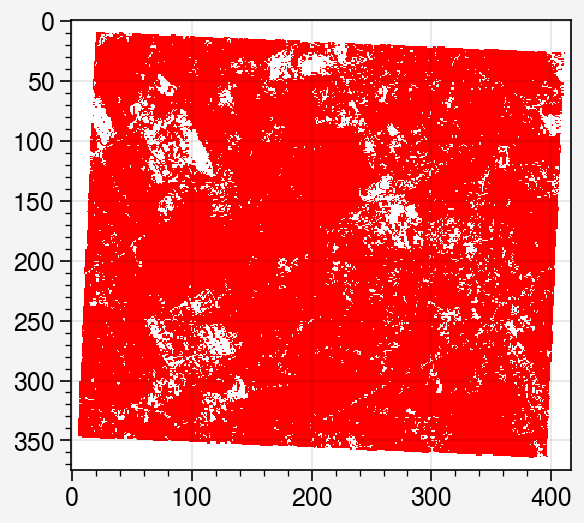

In [9]:
fig, ax = uplt.subplots()

ax.imshow(turkey_point_reproj[:, :, 4], color='red')